# Introduction

The following notebook it aimed at quantifying the movement of CDR domains in TCR variable regions between unbound (*apo*) and bound (*holo*) conformations. The *holo* conforomations in this case are TCRs bound to class I pMHC complexes.

In [1]:
import os
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

In [2]:
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

In [3]:
DATA_DIR = '../data/processed/apo-holo-tcr-pmhc-class-I-comparisons'

In [4]:
NOISE_LEVEL = 0.5 # Å

In [5]:
summary_df = pd.read_csv('../data/processed/apo-holo-tcr-pmhc-class-I/apo_holo_summary.csv')

ids = summary_df['file_name'].str.replace('.pdb', '')
ids.name = 'id'
summary_df = summary_df.set_index(ids)

summary_df

/var/scratch/bmcmaste/1355136/ipykernel_3343865/322943147.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  ids = summary_df['file_name'].str.replace('.pdb', '')


,file_name,pdb_id,structure_type,state,alpha_chain,beta_chain,antigen_chain,mhc_chain1,mhc_chain2,cdr_sequences_collated,peptide_sequence,mhc_slug
id,,,,,,,,,,,,
1ao7_D-E-C-A-B_tcr_pmhc,1ao7_D-E-C-A-B_tcr_pmhc.pdb,1ao7,tcr_pmhc,holo,D,E,C,A,B,DRGSQS-IYSNGD-AVTTDSWGKLQ-MNHEY-SVGAGI-ASRPGLA...,LLFGYPVYV,hla_a_02_01
1bd2_D-E-C-A-B_tcr_pmhc,1bd2_D-E-C-A-B_tcr_pmhc.pdb,1bd2,tcr_pmhc,holo,D,E,C,A,B,NSMFDY-ISSIKDK-AAMEGAQKLV-MNHEY-SVGAGI-ASSYPGG...,LLFGYPVYV,hla_a_02_01
1bii_A-B-P_pmhc,1bii_A-B-P_pmhc.pdb,1bii,pmhc,apo,NaN,NaN,P,A,B,NaN,RGPGRAFVTI,h2_dd
1ddh_A-B-P_pmhc,1ddh_A-B-P_pmhc.pdb,1ddh,pmhc,apo,NaN,NaN,P,A,B,NaN,RGPGRAFVTI,h2_dd
1duz_A-B-C_pmhc,1duz_A-B-C_pmhc.pdb,1duz,pmhc,apo,NaN,NaN,C,A,B,NaN,LLFGYPVYV,hla_a_02_01
...,...,...,...,...,...,...,...,...,...,...,...,...
8gon_D-E-C-A-B_tcr_pmhc,8gon_D-E-C-A-B_tcr_pmhc.pdb,8gon,tcr_pmhc,holo,D,E,C,A,B,TSESDYY-QEAYKQQN-ASSGNTPLV-SGHNS-FNNNVP-ASTWGR...,NaN,NaN
8gop_A-B_tcr,8gop_A-B_tcr.pdb,8gop,tcr,apo,A,B,NaN,NaN,NaN,TSESDYY-QEAYKQQN-ASSGNTPLV-SGHNS-FNNNVP-ASTWGR...,NaN,NaN
8gvb_A-B-P-H-L_tcr_pmhc,8gvb_A-B-P-H-L_tcr_pmhc.pdb,8gvb,tcr_pmhc,holo,A,B,P,H,L,YGATPY-YFSGDTLV-AVGFTGGGNKLT-SEHNR-FQNEAQ-ASSD...,RYPLTFGW,hla_a_24_02


## Calculating RMSD between conformations

Now that the structures have been align, RMSD can be computed between all states of the same TCR. Comparions between the different *apo* and *holo* forms are also done so that these can be used as a control for the differences in *apo* to *holo* comparisons. This process is done two different ways. The first, termed framework alignment, computes the comparison between TCRs after aligning on the framework region of the proteins. This method captures the "global" conformational changes that these loops undergo including any combined rotations and deformations. The second method, termed loop alignment, does the same calculations as the first method, but after aligning the two loops being compared on their backbones. This method captures the deformation aspects of loops regardless of any hinging from the framework region.

In [6]:
def categorize_movement(rmsd: float) -> str:
    if rmsd < NOISE_LEVEL:
        return 'Little Movement'

    if NOISE_LEVEL <= rmsd < 1.0:
        return 'Some Movement'

    if 1.0 <= rmsd < 2.0:
        return 'Movement'

    if 2.0 <= rmsd < 4.0:
        return 'Large Movement'

    if 4.0 <= rmsd:
        return 'Significant Movement'


movement_order = pd.CategoricalDtype(categories=['Little Movement', 'Some Movement', 'Movement', 'Large Movement', 'Significant Movement'], ordered=True)

### Framework Alignment

In [7]:
results_framework = pd.read_csv(os.path.join(DATA_DIR, 'rmsd_cdr_fw_align_results.csv'))

In [8]:
results_framework = results_framework.merge(
    summary_df[['cdr_sequences_collated', 'peptide_sequence', 'mhc_slug']],
    how='left',
    left_on='complex_id',
    right_index=True,
)

In [9]:
results_framework_holo_holo = pd.read_csv(os.path.join(DATA_DIR, 'rmsd_cdr_fw_align_holo.csv'))

In [10]:
results_framework_holo_holo['cdr_sequences_collated'] = None

results_framework_holo_holo['mhc_slug'] = None
results_framework_holo_holo['peptide_sequence'] = None

In [11]:
cdr_pattern = r'[A-Z]+-[A-Z]+-[A-Z]+-[A-Z]+-[A-Z]+-[A-Z]+'
cdr_complex_ids = results_framework_holo_holo['complex_id'].str.contains(cdr_pattern)

holo_cdr_sequences_collated = results_framework_holo_holo[cdr_complex_ids]['complex_id']
results_framework_holo_holo.loc[cdr_complex_ids, 'cdr_sequences_collated'] = holo_cdr_sequences_collated

In [12]:
results_framework_holo_holo = results_framework_holo_holo.query('cdr_sequences_collated.notnull()')

In [13]:
results_framework = pd.concat([results_framework, results_framework_holo_holo])

In [14]:
results_framework = results_framework.merge(
    summary_df[['file_name', 'pdb_id', 'structure_type', 'state', 'alpha_chain', 'beta_chain', 'antigen_chain', 'mhc_chain1', 'mhc_chain2']],
    how='left',
    left_on='structure_x_name',
    right_on='file_name',
).merge(
    summary_df[['file_name', 'pdb_id', 'structure_type', 'state', 'alpha_chain', 'beta_chain', 'antigen_chain', 'mhc_chain1', 'mhc_chain2']],
    how='left',
    left_on='structure_y_name',
    right_on='file_name',
    suffixes=('_x', '_y')
)

In [15]:
results_framework['comparison'] = results_framework['state_x'] + '-' + results_framework['state_y']
results_framework['comparison'] = results_framework['comparison'].map(lambda entry: 'apo-holo' if entry == 'holo-apo' else entry)

In [16]:
results_framework['structure_comparison'] = results_framework.apply(
    lambda row: '-'.join(sorted([row.structure_x_name, row.structure_y_name])),
    axis='columns',
)
results_framework = results_framework.drop_duplicates(['structure_comparison', 'chain_type', 'cdr'])

In [17]:
results_framework = results_framework.groupby(['cdr_sequences_collated', 'comparison', 'cdr', 'chain_type'])['rmsd'].mean().reset_index()

In [18]:
results_framework['movement'] = results_framework['rmsd'].map(categorize_movement).astype(movement_order)

In [19]:
results_framework

,cdr_sequences_collated,comparison,cdr,chain_type,rmsd,movement
0,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,apo-holo,1,alpha_chain,1.193604,Movement
1,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,apo-holo,1,beta_chain,0.473654,Little Movement
2,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,apo-holo,2,alpha_chain,0.905868,Some Movement
3,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,apo-holo,2,beta_chain,0.865963,Some Movement
4,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,apo-holo,3,alpha_chain,2.635113,Large Movement
...,...,...,...,...,...,...
318,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,apo-holo,1,beta_chain,0.646786,Some Movement
319,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,apo-holo,2,alpha_chain,2.650761,Large Movement
320,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,apo-holo,2,beta_chain,0.786869,Some Movement
321,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,apo-holo,3,alpha_chain,1.956881,Movement


## Loop Alignment

In [20]:
results_loop = pd.read_csv(os.path.join(DATA_DIR, 'rmsd_cdr_loop_align_results.csv'))

In [21]:
results_loop= results_loop.merge(
    summary_df[['cdr_sequences_collated', 'peptide_sequence', 'mhc_slug']],
    how='left',
    left_on='complex_id',
    right_index=True,
)

In [22]:
results_loop_holo_holo = pd.read_csv(os.path.join(DATA_DIR, 'rmsd_cdr_loop_align_holo.csv'))

In [23]:
results_loop_holo_holo['cdr_sequences_collated'] = None

results_loop_holo_holo['mhc_slug'] = None
results_loop_holo_holo['peptide_sequence'] = None

In [24]:
cdr_pattern = r'[A-Z]+-[A-Z]+-[A-Z]+-[A-Z]+-[A-Z]+-[A-Z]+'
cdr_complex_ids = results_loop_holo_holo['complex_id'].str.contains(cdr_pattern)

holo_cdr_sequences_collated = results_loop_holo_holo[cdr_complex_ids]['complex_id']
results_loop_holo_holo.loc[cdr_complex_ids, 'cdr_sequences_collated'] = holo_cdr_sequences_collated

In [25]:
results_loop_holo_holo = results_loop_holo_holo.query('cdr_sequences_collated.notnull()')

In [26]:
results_loop = pd.concat([results_loop, results_loop_holo_holo])

In [27]:
results_loop = results_loop.merge(
    summary_df[['file_name', 'pdb_id', 'structure_type', 'state', 'alpha_chain', 'beta_chain', 'antigen_chain', 'mhc_chain1', 'mhc_chain2']],
    how='left',
    left_on='structure_x_name',
    right_on='file_name',
).merge(
    summary_df[['file_name', 'pdb_id', 'structure_type', 'state', 'alpha_chain', 'beta_chain', 'antigen_chain', 'mhc_chain1', 'mhc_chain2']],
    how='left',
    left_on='structure_y_name',
    right_on='file_name',
    suffixes=('_x', '_y')
)

In [28]:
results_loop['comparison'] = results_loop['state_x'] + '-' + results_loop['state_y']
results_loop['comparison'] = results_loop['comparison'].map(lambda entry: 'apo-holo' if entry == 'holo-apo' else entry)

In [29]:
results_loop['structure_comparison'] = results_loop.apply(
    lambda row: '-'.join(sorted([row.structure_x_name, row.structure_y_name])),
    axis='columns',
)
results_loop = results_loop.drop_duplicates(['structure_comparison', 'chain_type', 'cdr'])

In [30]:
results_loop = results_loop.groupby(['cdr_sequences_collated', 'comparison', 'cdr', 'chain_type'])['rmsd'].mean().reset_index()

In [31]:
results_loop['movement'] = results_loop['rmsd'].map(categorize_movement).astype(movement_order)

In [32]:
results_loop

,cdr_sequences_collated,comparison,cdr,chain_type,rmsd,movement
0,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,apo-holo,1,alpha_chain,0.801538,Some Movement
1,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,apo-holo,1,beta_chain,0.239049,Little Movement
2,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,apo-holo,2,alpha_chain,0.725440,Some Movement
3,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,apo-holo,2,beta_chain,0.774079,Some Movement
4,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,apo-holo,3,alpha_chain,1.210009,Movement
...,...,...,...,...,...,...
318,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,apo-holo,1,beta_chain,0.113593,Little Movement
319,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,apo-holo,2,alpha_chain,1.082823,Movement
320,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,apo-holo,2,beta_chain,0.201656,Little Movement
321,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,apo-holo,3,alpha_chain,1.475462,Movement


# Visualizing and analysing the results

## Measuring the distance between apo and holo confomations

Since RMSD was calculated for all pairings of the same TCR, the apo-holo (or holo-apo) comparisons were selected.

### Framework Alignment

In [33]:
results_framework['chain_type_formatted'] = results_framework['chain_type'].str.replace('_', ' ').str.title()

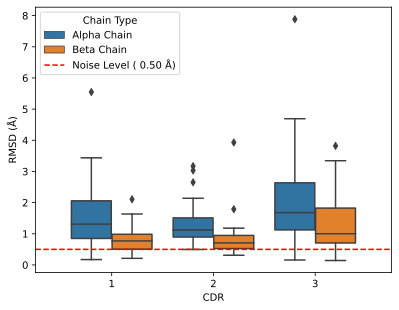

count      mean       std       min       25%       50%  \
chain_type  cdr                                                            
alpha_chain 1     25.0  1.625591  1.126121  0.172478  0.849734  1.308559   
            2     24.0  1.360652  0.725418  0.496448  0.894783  1.121992   
            3     25.0  2.205034  1.666278  0.157864  1.124128  1.678234   
beta_chain  1     25.0  0.818192  0.428709  0.211640  0.504221  0.770227   
            2     25.0  0.879987  0.718325  0.311457  0.526078  0.705481   
            3     25.0  1.375520  0.977938  0.142801  0.705002  1.001740   

                      75%       max  
chain_type  cdr                      
alpha_chain 1    2.056843  5.547374  
            2    1.509622  3.170339  
            3    2.635113  7.883364  
beta_chain  1    0.983855  2.106660  
            2    0.947803  3.928769  
            3    1.823828  3.820573

<Figure size 640x480 with 0 Axes>

In [34]:
sns.boxplot(data=results_framework.query("comparison == 'apo-holo'"), y='rmsd', x='cdr', hue='chain_type_formatted')

x = np.linspace(-0.75, 2.75)
y = np.repeat(NOISE_LEVEL, len(x))

plt.plot(x, y, '--r', label=f'Noise Level ({NOISE_LEVEL: .2f} Å)')
plt.xlim(-0.75, 2.75)

plt.legend(title='Chain Type')
plt.xlabel('CDR')
plt.ylabel('RMSD (Å)')

plt.show()
plt.savefig('../report/figures/cdr_framework_movement.svg')

results_framework.query("comparison == 'apo-holo'").groupby(['chain_type', 'cdr'])['rmsd'].describe()

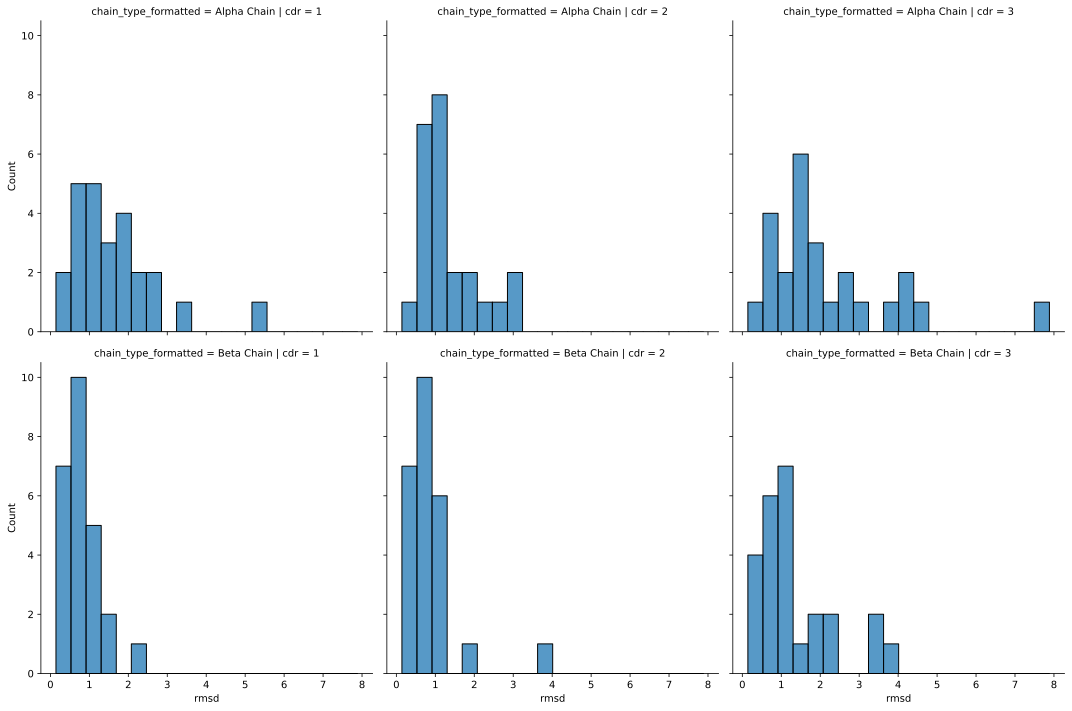

In [35]:
sns.displot(results_framework.query("comparison == 'apo-holo'"),
            x='rmsd', col='cdr', row='chain_type_formatted')

In [36]:
treatments = [(group, df['rmsd'].to_numpy()) for group, df in results_framework.query("comparison == 'apo-holo'").groupby(['chain_type', 'cdr'])]
print(scipy.stats.kruskal(*[values for _, values in treatments]))

KruskalResult(statistic=33.47222908277405, pvalue=3.0322000362602383e-06)


In [37]:
combos = [(((chain_x, cdr_x), sample_x), ((chain_y, cdr_y), sample_y))
          for ((chain_x, cdr_x), sample_x), ((chain_y, cdr_y), sample_y) in itertools.combinations(treatments, 2)
          if cdr_x == cdr_y]

significance_level = 0.05 / len(combos)

framework_stats = {
    'chain_type_x': [],
    'cdr_x': [],
    'chain_type_y': [],
    'cdr_y': [],
    'statistic': [],
    'p_val': [],
}

for ((chain_x, cdr_x), sample_x), ((chain_y, cdr_y), sample_y) in combos:
    stat, p_val = scipy.stats.ranksums(sample_x, sample_y)
    
    framework_stats['chain_type_x'].append(chain_x)
    framework_stats['cdr_x'].append(cdr_x)
    framework_stats['chain_type_y'].append(chain_y)
    framework_stats['cdr_y'].append(cdr_y)

    framework_stats['statistic'].append(stat)
    framework_stats['p_val'].append(p_val)

framework_stats = pd.DataFrame(framework_stats)
framework_stats['significant'] = framework_stats['p_val'] < significance_level

framework_stats

,chain_type_x,cdr_x,chain_type_y,cdr_y,statistic,p_val,significant
0,alpha_chain,1,beta_chain,1,3.346992,0.000817,True
1,alpha_chain,2,beta_chain,2,3.380000,0.000725,True
2,alpha_chain,3,beta_chain,3,2.202223,0.027650,False


In [38]:
combos = list(itertools.combinations([(cdr, df['rmsd'].to_numpy())
                                       for cdr, df in results_framework.query("comparison == 'apo-holo'").groupby('cdr')], 2))

significance_level = 0.05 / len(combos)

framework_stats = {
    'cdr_x': [],
    'cdr_y': [],
    'statistic': [],
    'p_val': [],
}

for (cdr_x, sample_x), (cdr_y, sample_y) in combos:
    stat, p_val = scipy.stats.ranksums(sample_x, sample_y)


    framework_stats['cdr_x'].append(cdr_x)
    framework_stats['cdr_y'].append(cdr_y)

    framework_stats['statistic'].append(stat)
    framework_stats['p_val'].append(p_val)

framework_stats = pd.DataFrame(framework_stats)
framework_stats['significant'] =  framework_stats['p_val'] < significance_level

framework_stats

,cdr_x,cdr_y,statistic,p_val,significant
0,1,2,0.335930,0.736924,False
1,1,3,-2.343899,0.019083,False
2,2,3,-2.820412,0.004796,True


The figure above shows there appears to be an increase in the movement of CDR3 compared to CDR1 and CDR2 and that the alpha chain has more movement than the beta chain of the TCR.

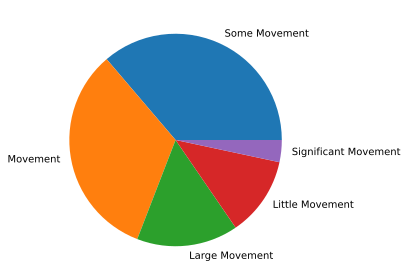

In [39]:
results_framework.query("comparison == 'apo-holo'")['movement'].value_counts().plot.pie()
plt.ylabel('')

plt.show()

### Loop Alignment

In [40]:
results_loop['chain_type_formatted'] = results_loop['chain_type'].str.replace('_', ' ').str.title()

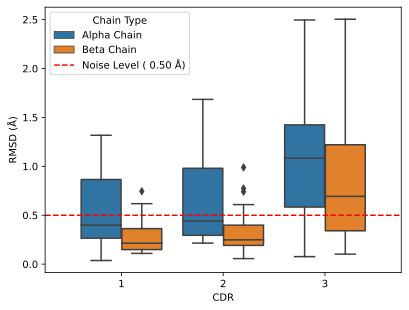

count      mean       std       min       25%       50%  \
chain_type  cdr                                                            
alpha_chain 1     25.0  0.539703  0.370003  0.037604  0.265344  0.398626   
            2     24.0  0.644121  0.446783  0.215395  0.294647  0.439994   
            3     25.0  1.121232  0.650441  0.077000  0.584030  1.083251   
beta_chain  1     25.0  0.279281  0.184982  0.110227  0.149009  0.214492   
            2     25.0  0.339790  0.232802  0.056751  0.191979  0.248698   
            3     25.0  0.886316  0.691293  0.102327  0.341379  0.693077   

                      75%       max  
chain_type  cdr                      
alpha_chain 1    0.865431  1.317612  
            2    0.979735  1.684088  
            3    1.423754  2.495455  
beta_chain  1    0.363066  0.744923  
            2    0.398983  0.988705  
            3    1.220448  2.503307

<Figure size 640x480 with 0 Axes>

In [41]:
sns.boxplot(data=results_loop.query("comparison == 'apo-holo'"), y='rmsd', x='cdr', hue='chain_type_formatted')

x = np.linspace(-0.75, 2.75)
y = np.repeat(NOISE_LEVEL, len(x))

plt.plot(x, y, '--r', label=f'Noise Level ({NOISE_LEVEL: .2f} Å)')
plt.xlim(-0.75, 2.75)

plt.legend(title='Chain Type')
plt.xlabel('CDR')
plt.ylabel('RMSD (Å)')

plt.show()
plt.savefig('../report/figures/cdr_loop_movement.svg')

results_loop.query("comparison == 'apo-holo'").groupby(['chain_type', 'cdr'])['rmsd'].describe()

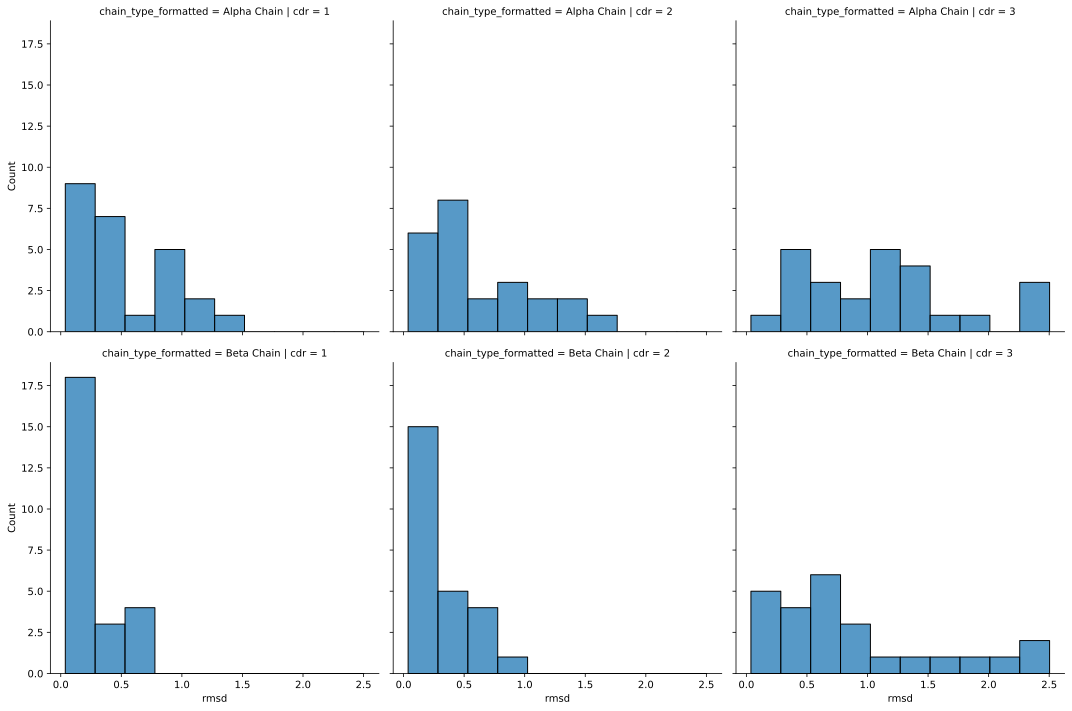

In [42]:
sns.displot(results_loop.query("comparison == 'apo-holo'"),
            x='rmsd', col='cdr', row='chain_type_formatted')

In [43]:
treatments = [(group, df['rmsd'].to_numpy()) for group, df in results_loop.query("comparison == 'apo-holo'").groupby(['chain_type', 'cdr'])]
print(scipy.stats.kruskal(*[values for _, values in treatments]))

KruskalResult(statistic=48.69824429530195, pvalue=2.5578145006489472e-09)


In [44]:
combos = [(((chain_x, cdr_x), sample_x), ((chain_y, cdr_y), sample_y))
          for ((chain_x, cdr_x), sample_x), ((chain_y, cdr_y), sample_y) in itertools.combinations(treatments, 2)
          if cdr_x == cdr_y]

significance_level = 0.05 / len(combos)

loop_stats = {
    'chain_x': [],
    'cdr_x': [],
    'chain_y': [],
    'cdr_y': [],
    'statistic': [],
    'p_val': [],
}

for ((chain_x, cdr_x), sample_x), ((chain_y, cdr_y), sample_y) in combos:
    stat, p_val = scipy.stats.ranksums(sample_x, sample_y)

    loop_stats['chain_x'].append(chain_x)
    loop_stats['cdr_x'].append(cdr_x)
    loop_stats['chain_y'].append(chain_y)
    loop_stats['cdr_y'].append(cdr_y)

    loop_stats['statistic'].append(stat)
    loop_stats['p_val'].append(p_val)

loop_stats = pd.DataFrame(loop_stats)

loop_stats['significant'] = loop_stats['p_val'] < significance_level

loop_stats

,chain_x,cdr_x,chain_y,cdr_y,statistic,p_val,significant
0,alpha_chain,1,beta_chain,1,3.172366,0.001512,True
1,alpha_chain,2,beta_chain,2,3.120000,0.001809,True
2,alpha_chain,3,beta_chain,3,1.600735,0.109436,False


In [45]:
combos = list(itertools.combinations([(cdr, df['rmsd'].to_numpy())
                                      for cdr, df in results_loop.query("comparison == 'apo-holo'").groupby('cdr')], 2))

significance_level = 0.05 / len(combos)

loop_stats = {
    'cdr_x': [],
    'cdr_y': [],
    'statistic': [],
    'p_val': [],
}

for (cdr_x, sample_x), (cdr_y, sample_y) in combos:
    stat, p_val = scipy.stats.ranksums(sample_x, sample_y)

    loop_stats['cdr_x'].append(cdr_x)
    loop_stats['cdr_y'].append(cdr_y)

    loop_stats['statistic'].append(stat)
    loop_stats['p_val'].append(p_val)

loop_stats = pd.DataFrame(loop_stats)

loop_stats['significant'] = loop_stats['p_val'] < significance_level

loop_stats

,cdr_x,cdr_y,statistic,p_val,significant
0,1,2,-1.252739,2.103007e-01,False
1,1,3,-5.053170,4.345369e-07,True
2,2,3,-4.325099,1.524634e-05,True


The figure above shows there appears to be an increase in the movement of CDR3 compared to CDR1 and CDR2 and that the alpha chain has more movement than the beta chain of the TCR.

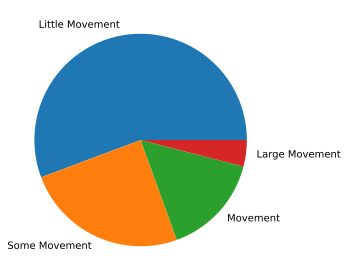

In [46]:
results_loop.query("comparison == 'apo-holo'")['movement'].value_counts().plot.pie()

plt.ylabel('')

plt.show()

## Comparison of *apo*-*holo*, *apo*-*apo* and *holo*-*holo* conformational changes

The following analysis aims to ascertain whether there is notable movement in the CDR domains between the *apo* and *holo* conformations, using *apo*-*apo* and *holo*-*holo* differences as controls.

### Framework Alignment

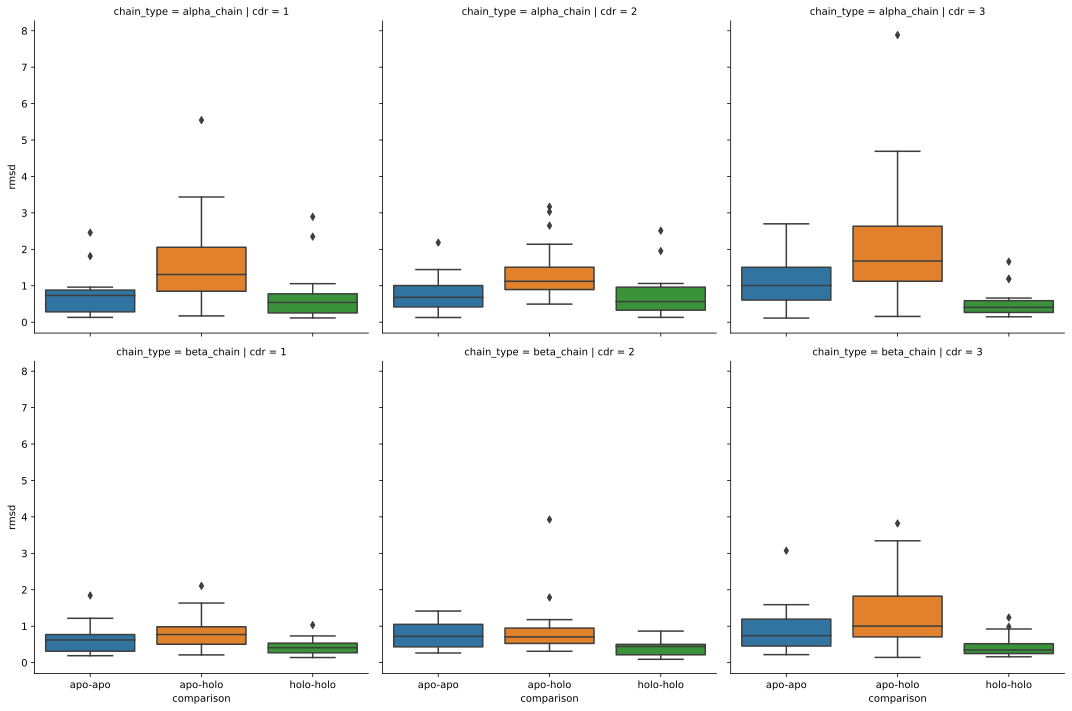

In [47]:
sns.catplot(results_framework.sort_values(['comparison', 'chain_type', 'cdr']),
            x='comparison',
            y='rmsd',
            col='cdr',
            row='chain_type',
            kind='box')

plt.savefig('../report/figures/cdr_framework_movement_comparison.svg')

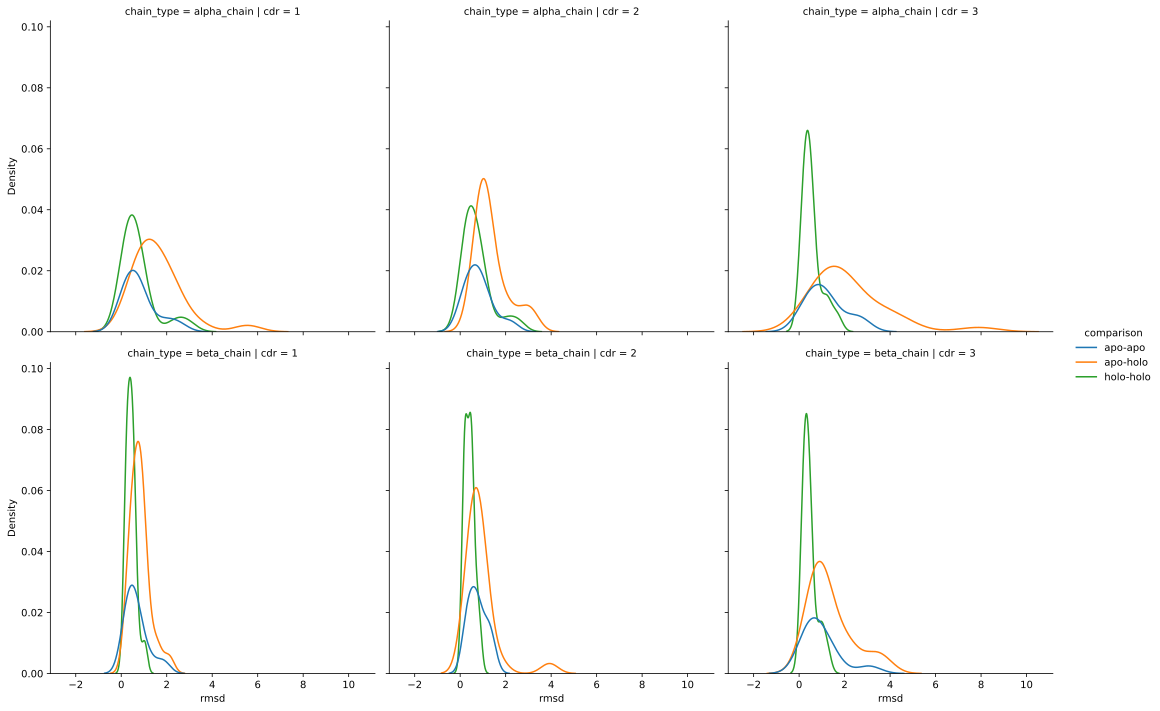

In [48]:
sns.displot(results_framework.sort_values(['comparison', 'chain_type', 'cdr']),
            hue='comparison',
            x='rmsd',
            col='cdr',
            row='chain_type',
            kind='kde')

In [49]:
treatment_options = ['comparison', 'chain_type', 'cdr']
treatments = [(group, df['rmsd'].to_numpy()) for group, df in results_framework.groupby(treatment_options)]
treatments
print(scipy.stats.kruskal(*[values for _, values in treatments]))

KruskalResult(statistic=112.0659833804159, pvalue=4.924957542598049e-16)


In [50]:
combos = []
for pairing in list(itertools.combinations(treatments, 2)):
    chain_type_x = pairing[0][0][1]
    cdr_x = pairing[0][0][2]
    chain_type_y = pairing[1][0][1]
    cdr_y = pairing[1][0][2]

    if (chain_type_x, cdr_x) == (chain_type_y, cdr_y):
        combos.append(pairing)

significance_level = 0.05 / len(combos)
print(significance_level)
statistics = []
p_vals = []

for ((comparison_x, chain_type_x, cdr_x), sample_x), ((comparison_y, chain_type_y, cdr_y), sample_y) in combos:
    stat, p_val = scipy.stats.ranksums(sample_x, sample_y)

    statistics.append(stat)
    p_vals.append(p_val)

pd.DataFrame({
    'comparison_x': [name for ((name, _, _), _), _ in combos],
    'chain_type_x': [name for ((_, name, _), _), _ in combos],
    'cdr_x': [name for ((_, _, name), _), _ in combos],
    'comparison_y': [name for _, ((name, _, _), _) in combos],
    'chain_type_y': [name for _, ((_, name, _), _) in combos],
    'cdr_y': [name for _, ((_, _, name), _) in combos],
    'statistic': statistics,
    'p_val': p_vals,
    'significant': [p_val < significance_level for p_val in p_vals],
})

0.002777777777777778


,comparison_x,chain_type_x,cdr_x,comparison_y,chain_type_y,cdr_y,statistic,p_val,significant
0,apo-apo,alpha_chain,1,apo-holo,alpha_chain,1,-2.558466,0.010514,False
1,apo-apo,alpha_chain,1,holo-holo,alpha_chain,1,0.404520,0.685830,False
2,apo-apo,alpha_chain,2,apo-holo,alpha_chain,2,-2.274141,0.022958,False
3,apo-apo,alpha_chain,2,holo-holo,alpha_chain,2,0.404520,0.685830,False
4,apo-apo,alpha_chain,3,apo-holo,alpha_chain,3,-2.215048,0.026757,False
5,apo-apo,alpha_chain,3,holo-holo,alpha_chain,3,2.112493,0.034644,False
6,apo-apo,beta_chain,1,apo-holo,beta_chain,1,-1.356502,0.174939,False
7,apo-apo,beta_chain,1,holo-holo,beta_chain,1,1.303453,0.192420,False
8,apo-apo,beta_chain,2,apo-holo,beta_chain,2,-0.188880,0.850187,False
9,apo-apo,beta_chain,2,holo-holo,beta_chain,2,2.382173,0.017211,False


In [51]:
combos = list(itertools.combinations(treatments, 2))

significance_level = 0.05 / len(combos)

statistics = []
p_vals = []

for ((comparison_x, chain_type_x, cdr_x), sample_x), ((comparison_y, chain_type_y, cdr_y), sample_y) in combos:
    stat, p_val = scipy.stats.ranksums(sample_x, sample_y)

    statistics.append(stat)
    p_vals.append(p_val)

pd.DataFrame({
    'comparison_x': [name for ((name, _, _), _), _ in combos],
    'chain_type_x': [name for ((_, name, _), _), _ in combos],
    'cdr_x': [name for ((_, _, name), _), _ in combos],
    'comparison_y': [name for _, ((name, _, _), _) in combos],
    'chain_type_y': [name for _, ((_, name, _), _) in combos],
    'cdr_y': [name for _, ((_, _, name), _) in combos],
    'statistic': statistics,
    'p_val': p_vals,
    'significant': [p_val < significance_level for p_val in p_vals],
})

,comparison_x,chain_type_x,cdr_x,comparison_y,chain_type_y,cdr_y,statistic,p_val,significant
0,apo-apo,alpha_chain,1,apo-apo,alpha_chain,2,-0.229828,0.818226,False
1,apo-apo,alpha_chain,1,apo-apo,alpha_chain,3,-1.214803,0.224441,False
2,apo-apo,alpha_chain,1,apo-apo,beta_chain,1,0.164163,0.869603,False
3,apo-apo,alpha_chain,1,apo-apo,beta_chain,2,-0.361158,0.717982,False
4,apo-apo,alpha_chain,1,apo-apo,beta_chain,3,-0.623818,0.532747,False
...,...,...,...,...,...,...,...,...,...
148,holo-holo,alpha_chain,3,holo-holo,beta_chain,2,0.601133,0.547751,False
149,holo-holo,alpha_chain,3,holo-holo,beta_chain,3,0.664411,0.506428,False
150,holo-holo,beta_chain,1,holo-holo,beta_chain,2,0.506218,0.612704,False
151,holo-holo,beta_chain,1,holo-holo,beta_chain,3,0.474579,0.635087,False


The analysis of the plots and statistical tests shows that there is a statistically significant (p-value: 0.05) difference between the target and controls (as seen by the results of the Kruskal-Wallis test) but it also shows that there is a significant difference between the two controls.

### Loop Alignment

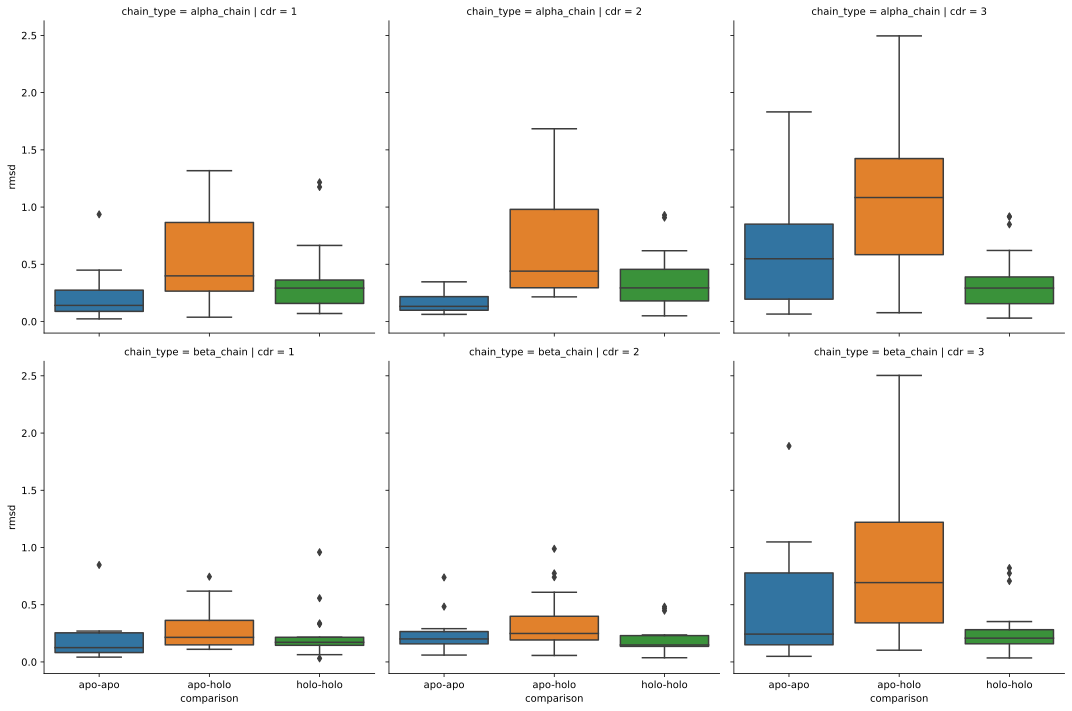

In [52]:
sns.catplot(results_loop.sort_values(['comparison', 'chain_type', 'cdr']),
            x='comparison',
            y='rmsd',
            col='cdr',
            row='chain_type',
            kind='box')

plt.savefig('../report/figures/cdr_loop_movement_comparison.svg')

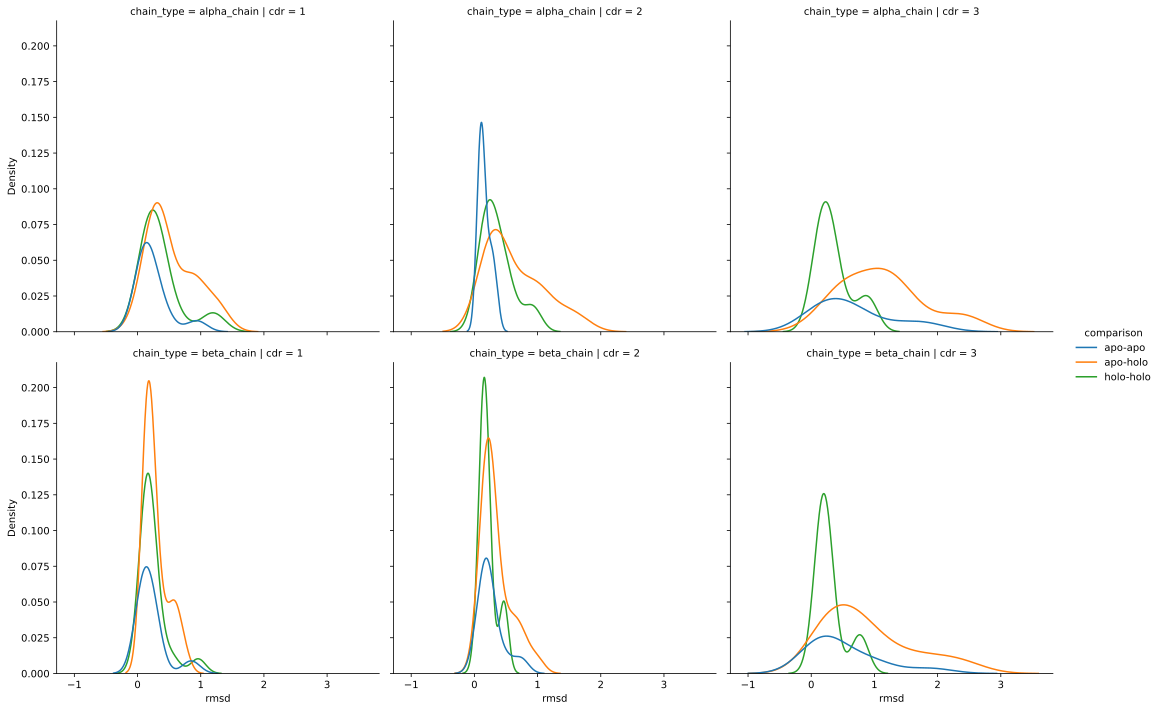

In [53]:
sns.displot(results_loop.sort_values(['comparison', 'chain_type', 'cdr']),
            x='rmsd',
            hue='comparison',
            col='cdr',
            row='chain_type',
            kind='kde')

In [54]:
treatment_options = ['comparison', 'chain_type', 'cdr']
treatments = [(group, df['rmsd'].to_numpy()) for group, df in results_loop.groupby(treatment_options)]
treatments
print(scipy.stats.kruskal(*[values for _, values in treatments]))

KruskalResult(statistic=106.74425009179026, pvalue=4.928764973630228e-15)


In [55]:
combos = []
for pairing in list(itertools.combinations(treatments, 2)):
    chain_type_x = pairing[0][0][1]
    cdr_x = pairing[0][0][2]
    chain_type_y = pairing[1][0][1]
    cdr_y = pairing[1][0][2]

    if (chain_type_x, cdr_x) == (chain_type_y, cdr_y):
        combos.append(pairing)

significance_level = 0.05 / len(combos)
print(significance_level)
statistics = []
p_vals = []

for ((comparison_x, chain_type_x, cdr_x), sample_x), ((comparison_y, chain_type_y, cdr_y), sample_y) in combos:
    stat, p_val = scipy.stats.ranksums(sample_x, sample_y)

    statistics.append(stat)
    p_vals.append(p_val)

pd.DataFrame({
    'comparison_x': [name for ((name, _, _), _), _ in combos],
    'chain_type_x': [name for ((_, name, _), _), _ in combos],
    'cdr_x': [name for ((_, _, name), _), _ in combos],
    'comparison_y': [name for _, ((name, _, _), _) in combos],
    'chain_type_y': [name for _, ((_, name, _), _) in combos],
    'cdr_y': [name for _, ((_, _, name), _) in combos],
    'statistic': statistics,
    'p_val': p_vals,
    'significant': [p_val < significance_level for p_val in p_vals],
})

0.002777777777777778


,comparison_x,chain_type_x,cdr_x,comparison_y,chain_type_y,cdr_y,statistic,p_val,significant
0,apo-apo,alpha_chain,1,apo-holo,alpha_chain,1,-2.592808,0.009520,False
1,apo-apo,alpha_chain,1,holo-holo,alpha_chain,1,-1.663026,0.096307,False
2,apo-apo,alpha_chain,2,apo-holo,alpha_chain,2,-3.979747,0.000069,True
3,apo-apo,alpha_chain,2,holo-holo,alpha_chain,2,-2.517013,0.011835,False
4,apo-apo,alpha_chain,3,apo-holo,alpha_chain,3,-1.974655,0.048307,False
5,apo-apo,alpha_chain,3,holo-holo,alpha_chain,3,1.303453,0.192420,False
6,apo-apo,beta_chain,1,apo-holo,beta_chain,1,-1.665579,0.095797,False
7,apo-apo,beta_chain,1,holo-holo,beta_chain,1,-0.764093,0.444812,False
8,apo-apo,beta_chain,2,apo-holo,beta_chain,2,-1.150451,0.249958,False
9,apo-apo,beta_chain,2,holo-holo,beta_chain,2,0.898933,0.368688,False


In [56]:
combos = list(itertools.combinations(treatments, 2))

significance_level = 0.05 / len(combos)

statistics = []
p_vals = []

for ((comparison_x, chain_type_x, cdr_x), sample_x), ((comparison_y, chain_type_y, cdr_y), sample_y) in combos:
    stat, p_val = scipy.stats.ranksums(sample_x, sample_y)

    statistics.append(stat)
    p_vals.append(p_val)

pd.DataFrame({
    'comparison_x': [name for ((name, _, _), _), _ in combos],
    'chain_type_x': [name for ((_, name, _), _), _ in combos],
    'cdr_x': [name for ((_, _, name), _), _ in combos],
    'comparison_y': [name for _, ((name, _, _), _) in combos],
    'chain_type_y': [name for _, ((_, name, _), _) in combos],
    'cdr_y': [name for _, ((_, _, name), _) in combos],
    'statistic': statistics,
    'p_val': p_vals,
    'significant': [p_val < significance_level for p_val in p_vals],
})

,comparison_x,chain_type_x,cdr_x,comparison_y,chain_type_y,cdr_y,statistic,p_val,significant
0,apo-apo,alpha_chain,1,apo-apo,alpha_chain,2,0.689483,0.490520,False
1,apo-apo,alpha_chain,1,apo-apo,alpha_chain,3,-2.134113,0.032834,False
2,apo-apo,alpha_chain,1,apo-apo,beta_chain,1,0.558153,0.576740,False
3,apo-apo,alpha_chain,1,apo-apo,beta_chain,2,-0.820813,0.411753,False
4,apo-apo,alpha_chain,1,apo-apo,beta_chain,3,-1.280468,0.200381,False
...,...,...,...,...,...,...,...,...,...
148,holo-holo,alpha_chain,3,holo-holo,beta_chain,2,2.056509,0.039733,False
149,holo-holo,alpha_chain,3,holo-holo,beta_chain,3,0.727688,0.466805,False
150,holo-holo,beta_chain,1,holo-holo,beta_chain,2,0.284747,0.775838,False
151,holo-holo,beta_chain,1,holo-holo,beta_chain,3,-1.328821,0.183907,False
